<a href="https://colab.research.google.com/github/JaehyeongWang/swe3032_team7/blob/yuha/models/LSTM/main_final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/인지프/models')

In [ ]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocesslib import preprocessEach, makeY

In [ ]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

/content/drive/MyDrive/인지프/models/preprocesslib.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/content/drive/MyDrive/인지프/models/preprocesslib.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/content/drive/MyDrive/인지프/models/preprocesslib.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/content/drive/MyDrive/인지프/models/prepr

In [ ]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [ ]:
#make y values
yGrowths = makeY('growth', len(xGrowths))
yValues = makeY('value', len(xValues))
yOverlaps = makeY('overlap', len(xOverlaps))

In [ ]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [ ]:
x.shape

(3213, 1248, 6)

In [ ]:
y = np.array([i[0] for i in y])

In [ ]:
y.shape

(3213,)

In [ ]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

## lstm

### cv

In [ ]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [ ]:
x_split, y_split = splitDataCrossVal(x,y)

In [ ]:
# for later use
'''model = Sequential()
model.add(LSTM(32, input_shape=(1248,6), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(2, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])'''

"model = Sequential()\nmodel.add(LSTM(32, input_shape=(1248,6), return_sequences=True))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(16))\nmodel.add(Dense(2, activation='sigmoid'))\nes = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)\nmc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])"

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(1248,6), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#cross validation

accuracy_cross_val = []
for i in range(len(x_split)):
  x_train, x_test, y_train, y_test = splitData(x_split[i], y_split[i])
  x_train = pad_sequences(x_train, dtype='float32')
  x_test = pad_sequences(x_test, dtype='float32')
  x_train = np.nan_to_num(x_train, nan=0)
  x_test = np.nan_to_num(x_test, nan=0)

  history=model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[es, mc])
  model=load_model('best_model.h5')
  loss, accuracy = model.evaluate(x_test, y_test)
  accuracy_cross_val.append(accuracy)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

Epoch 1/2000
6/6 [==============================] - 9s 165ms/step - loss: 0.6788 - acc: 0.5804 - val_loss: 0.6335 - val_acc: 0.6977
Epoch 2/2000
6/6 [==============================] - 0s 48ms/step - loss: 0.6433 - acc: 0.6740 - val_loss: 0.6072 - val_acc: 0.6977
Epoch 3/2000
6/6 [==============================] - 0s 49ms/step - loss: 0.6232 - acc: 0.6842 - val_loss: 0.6048 - val_acc: 0.6977
Epoch 4/2000
6/6 [==============================] - 0s 45ms/step - loss: 0.6259 - acc: 0.6842 - val_loss: 0.6038 - val_acc: 0.6977
Epoch 5/2000
6/6 [==============================] - 0s 44ms/step - loss: 0.6211 - acc: 0.6842 - val_loss: 0.6053 - val_acc: 0.6977
Epoch 6/2000
6/6 [==============================] - 0s 51ms/step - loss: 0.6174 - acc: 0.6842 - val_loss: 0.6048 - val_acc: 0.6977
Epoch 7/2000
6/6 [==============================] - 0s 49ms/step - loss: 0.6099 - acc: 0.6842 - val_loss: 0.6023 - val_acc: 0.6977
Epoch 8/2000
6/6 [==============================] - 0s 60ms/step - loss: 0.6021 - 

### full data

In [ ]:
x_train, x_test, y_train, y_test = splitData(x, y)

#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [ ]:
x_train.shape

(2570, 1248, 6)

In [ ]:
y_train.shape

(2570,)

In [ ]:
history=model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Epoch 1/2000
17/17 [==============================] - 2s 52ms/step - loss: 0.5984 - acc: 0.6712 - val_loss: 0.5911 - val_acc: 0.6926
Epoch 2/2000
17/17 [==============================] - 1s 39ms/step - loss: 0.5961 - acc: 0.6853 - val_loss: 0.5930 - val_acc: 0.6887
Epoch 3/2000
17/17 [==============================] - 1s 43ms/step - loss: 0.5962 - acc: 0.6853 - val_loss: 0.5876 - val_acc: 0.6946
Epoch 4/2000
17/17 [==============================] - 1s 39ms/step - loss: 0.5983 - acc: 0.6717 - val_loss: 0.5903 - val_acc: 0.6946
Epoch 5/2000
17/17 [==============================] - 1s 40ms/step - loss: 0.5943 - acc: 0.6780 - val_loss: 0.5890 - val_acc: 0.6926
Epoch 6/2000
17/17 [==============================] - 1s 39ms/step - loss: 0.5934 - acc: 0.6668 - val_loss: 0.5873 - val_acc: 0.6887
Epoch 7/2000
17/17 [==============================] - 1s 39ms/step - loss: 0.5923 - acc: 0.6863 - val_loss: 0.6038 - val_acc: 0.6732
Epoch 8/2000
17/17 [==============================] - 1s 39ms/step - 

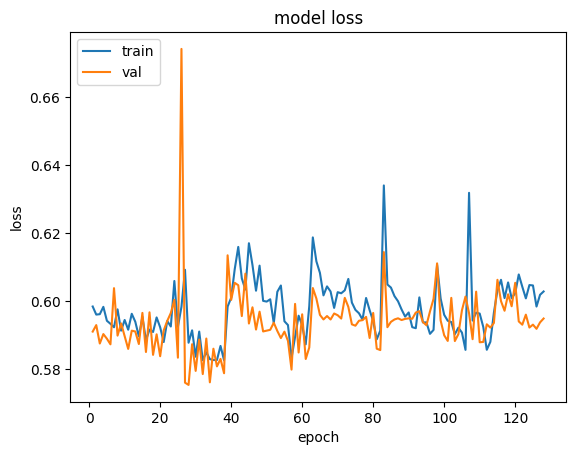

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

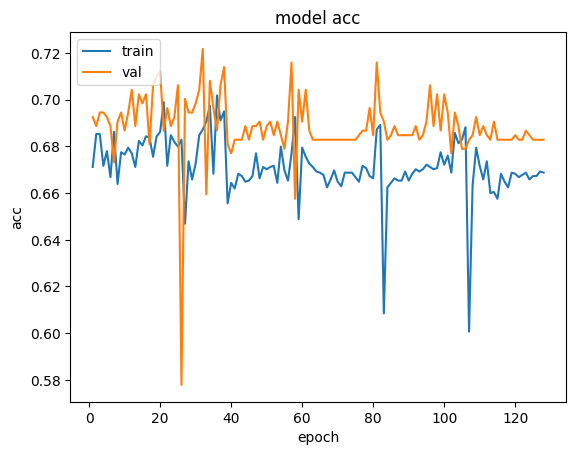

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model=load_model('best_model.h5')
loss, accuracy = model.evaluate(x_test, y_test)

21/21 [==============================] - 1s 26ms/step - loss: 0.6083 - acc: 0.6983


In [ ]:
print(accuracy, loss)

0.6982892751693726 0.6082624197006226


In [ ]:
model.predict(x_test)

21/21 [==============================] - 1s 21ms/step


array([[0.8350073 ],
       [0.7760131 ],
       [0.4046197 ],
       [0.85406053],
       [0.420857  ],
       [0.40725407],
       [0.7254432 ],
       [0.8738731 ],
       [0.46660885],
       [0.78651315],
       [0.69417375],
       [0.8780253 ],
       [0.90952826],
       [0.7195572 ],
       [0.5019533 ],
       [0.7251245 ],
       [0.5046565 ],
       [0.7784846 ],
       [0.6824448 ],
       [0.4176048 ],
       [0.81154823],
       [0.77865434],
       [0.71468514],
       [0.7195572 ],
       [0.84195197],
       [0.92770046],
       [0.49294037],
       [0.4448138 ],
       [0.8073698 ],
       [0.7690893 ],
       [0.7174877 ],
       [0.7756145 ],
       [0.8897886 ],
       [0.7387891 ],
       [0.76646197],
       [0.9308406 ],
       [0.83880335],
       [0.7159146 ],
       [0.7386676 ],
       [0.78321433],
       [0.64985305],
       [0.80681306],
       [0.74496365],
       [0.40966097],
       [0.7217345 ],
       [0.6976546 ],
       [0.40435076],
       [0.454

In [ ]:
result = pd.DataFrame(columns=['epochs', 'units', 'dropouts', 'layers','batchs', 'test_acc', 'test_loss'])
result.loc[0] = [2000, [32, 16], 0.2, 2, 64, 0.68, 0.62]
result.loc[1] = [2000, [32, 16], None, 2, 64, 0.66, 0.62]
result.loc[2] = [2000, [32, 16], None, 2, 32, 0.62, 0.63]
result.loc[3] = [2000, [32, 16], 0.2, 2, 32, ]
result

,epochs,units,dropouts,layers,batchs,test_acc,test_loss
0,2000,"[32, 16]",0.2,2,64,0.68,0.62
1,2000,"[32, 16]",NaN,2,64,0.66,0.62
2,2000,"[32, 16]",NaN,2,32,0.62,0.63


In [ ]:
'''from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

tscv = TimeSeriesSplit(n_splits=3)
model = KerasClassifier(build_fn=create_model, epochs=200)
cross_val_score(model, x, y, cv=tscv)'''

'from sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.model_selection import cross_val_score\nfrom keras.wrappers.scikit_learn import KerasClassifier\n\ntscv = TimeSeriesSplit(n_splits=3)\nmodel = KerasClassifier(build_fn=create_model, epochs=200)\ncross_val_score(model, x, y, cv=tscv)'